In [1]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)
mpl.rc('axes', labelsize=12)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
os.getcwd()

'C:\\Users\\efink\\Documents\\Github\\crossmodal\\Figure7'

In [3]:
os.chdir(r'C:\Users\efink\Documents\Data\crossmodal_only')

In [4]:
glob.glob('S1*')

['S1_microstim_log.mat', 'S1_stim_behvior.pdf', 'S1_stim_behvior.png']

In [5]:
log = sp.io.loadmat('S1_microstim_log.mat')

In [6]:
cols = ['mouse_name', 'date', 'block_type', 'stim_type', 'trial_num','touch_stim', 'vis_stim', 'resp']
beh_log = pd.DataFrame(log['all_session_beh'], columns = cols).applymap(lambda x: x[0])
beh_log[['trial_num','resp']] = beh_log[['trial_num','resp']].applymap(lambda x: x[0])

beh_log['mouse_name'] = beh_log['mouse_name'].apply(lambda x: x[-6:])
beh_log = beh_log[~(beh_log['block_type'] == 'Change')]
beh_log.head()

,mouse_name,date,block_type,stim_type,trial_num,touch_stim,vis_stim,resp
0,EF0147,12-04-18,Visual,Stim_Vis_NoCue,1,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,1
1,EF0147,12-04-18,Visual,Stim_Som_NoCue,2,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,1
2,EF0147,12-04-18,Visual,Stim_Som_NoCue,3,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2
3,EF0147,12-04-18,Visual,Stim_Vis_NoCue,4,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,3
4,EF0147,12-04-18,Visual,Stim_Vis_NoCue,5,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2


In [7]:
beh_log['mouse_name'].unique()

array(['EF0147', 'EF0148', 'EF0149', 'EF0150'], dtype=object)

In [8]:
beh_log['correct'] = 0
match = (((beh_log['block_type'] == 'Whisker') & (beh_log['stim_type'].str.contains('Som|catch', regex = True))) | 
         ((beh_log['block_type'] == 'Visual') & (beh_log['stim_type'].str.contains('Vis'))))

correct = (match & beh_log['resp'].isin([1,2])) | (~match & (beh_log['resp'] == 0))

beh_log.loc[correct, 'correct'] = 1

In [9]:
def bootstrap_means(df,random_state = 42, replace = True):
    ## resamples with replacement all the trials within a session_type but across days (ie sham or long stim inhibition). 
    ## Then calculates mean lick rate for the trial type
    
    df = df.sample(frac = 1, replace = replace, random_state = random_state)
    
    grps = df.groupby(['block_type','stim_type'])
    inds = grps.groups
    grp_names = list(grps.groups.keys())[::-1]
    grp_responses = {grp:(df.loc[inds[grp],'resp'].isin([1,2])).as_matrix() for grp in grp_names}
#     import pdb; pdb.set_trace()

    grp_means = {name:[np.mean(grp)] for name, grp in grp_responses.items()}
    grp_means = {name:value for name, value in zip(grp_names, grp_means.values())}
    
#     trials_to_remove = [key for key in grp_means.keys() if (key[2] not in [0.05, 0, 1, 'No_laser'])]
#     for key in trials_to_remove: grp_means.pop(key)
    
    return pd.DataFrame(grp_means)

In [10]:
%pdb

Automatic pdb calling has been turned ON


In [11]:
def calc_grp_means(df):
    
    samp_mean = bootstrap_means(df, replace = False)
    resamp_means = pd.concat([bootstrap_means(df, random_state = n) for n in range(1000)])
    resamp_means = resamp_means.reset_index(drop = True)
#     test_stats = samp_mean - means
    means = resamp_means.apply(np.mean, axis = 0)
    sem = resamp_means.apply(np.std, axis = 0)
    return means, sem

In [12]:
sham = {'EF0147': ['12-14-18', '12-15-18', '12-17-18'], 
        'EF0148':['12-10-18', '12-15-18', '12-17-18'], 
        'EF0149': ['12-11-18', '12-14-18', '12-16-18'],
        'EF0150': ['12-17-18', '12-19-18', '12-20-18', '12-21-18']}

stim = {'EF0147': ['12-08-18', '12-11-18', '12-13-18', '12-16-18'], 
        'EF0148':['12-11-18', '12-14-18', '12-16-18'], 
        'EF0149': ['12-13-18', '12-15-18', '12-17-18'],
        'EF0150': ['12-13-18', '12-14-18', '12-18-18', '12-28-18']}


In [13]:
sham_days = pd.concat([pd.DataFrame({mouse:dates}).stack() for mouse, dates in sham.items()])
stim_days = pd.concat([pd.DataFrame({mouse:dates}).stack() for mouse, dates in stim.items()])
sham_days = sham_days.reset_index().drop('level_0', axis = 1)
stim_days = stim_days.reset_index().drop('level_0', axis = 1)

sham_days['session_type'] = 'sham'
stim_days['session_type'] = 'stim'

test_days = pd.concat([stim_days,sham_days])
test_days = test_days.rename(columns = {'level_1': 'mouse_name', 0:'date'})
beh_log_test = beh_log.merge(test_days, on = ['mouse_name', 'date'])

In [14]:
beh_grouped = beh_log_test.groupby(['mouse_name', 'session_type'])

In [15]:
beh_performance = {mouse:calc_grp_means(grp) for mouse,grp in tqdm_notebook(beh_grouped)}

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [16]:
# # day_gen = (beh_performance.loc)
# for i in range(3):
#     fig, axes = mpl.subplots(4,4, figsize = (16,16), sharey = True, sharex = True)
#     fig.subplots_adjust(hspace = .2)
#     for ax in np.ravel(axes):
#         session, day_df = next(day_gen)
#         lick_df = sum_lick_trials(day_df)
#         plot_licks(lick_df, ax, session)

In [17]:
def plot_perf(bs_means, sem, ax1, ax2, subp_title):
    bs_means_dict = bs_means.to_dict()
    sem_dict = sem.to_dict()
    colors = ['k', 'C1', '#29ABE2']*2
    whisker_grps = {}; visual_grps = {}
    for i, grp in enumerate(bs_means.keys()):

        mean = bs_means_dict[grp]
        sem_grp = sem_dict[grp]

#         grp = list(grp)
#         grp[2] = str(grp[2])
#         if grp[1] == 'catch':
#             grp.pop(2)

        if grp[0] == 'Whisker':
            
            ax1.set_title(subp_title[0])
            ax1.scatter(' - '.join(grp[1:]), mean, color = colors[i], s = 80)
            ax1.vlines(' - '.join(grp[1:]), mean-sem_grp, mean+sem_grp, color = colors[i])
            ax1.set_ylim(0,1)
            mpl.sca(ax1); mpl.xticks( rotation = '60', ha = 'right')
            whisker_grps[' - '.join(grp[1:])] = mean 
        else:
            ax2.set_title(subp_title[1])
            ax2.scatter(' - '.join(grp[1:]), mean, color = colors[i], s = 80)
            ax2.vlines(' - '.join(grp[1:]), mean-sem_grp, mean+sem_grp, color = colors[i])
            ax2.set_ylim(0,1)
            visual_grps[' - '.join(grp[1:])] = mean 
            mpl.sca(ax2); mpl.xticks(rotation = 'vertical'); mpl.xticks(rotation = '60', ha = 'right')
            
    ax1.plot(whisker_grps.keys(), whisker_grps.values(), color = [0.4, 0.4, 0.4], ls = 'solid', alpha = 0.3)
    ax2.plot(visual_grps.keys(), visual_grps.values(), color = [0.4, 0.4, 0.4], ls = 'solid', alpha = 0.3)
    
    ax1.set_ylabel('Lick rate')
    
    for ax in [ax1,ax2]:
        ax.set_xticklabels(['Touch stim', 'Visual stim', 'S1 laser stim'])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    mpl.subplots_adjust(hspace = 0.3)
#     fig.tight_layout

In [18]:
beh_performance[('EF0148', 'stim')]

(Visual   Stim_Som_NoCue    0.075078
          Stim_Vis_NoCue    0.487298
          catch             0.280636
 Whisker  Stim_Som_NoCue    0.561357
          Stim_Vis_NoCue    0.077418
          catch             0.637911
 dtype: float64, Visual   Stim_Som_NoCue    0.037394
          Stim_Vis_NoCue    0.061181
          catch             0.092454
 Whisker  Stim_Som_NoCue    0.069385
          Stim_Vis_NoCue    0.034338
          catch             0.092843
 dtype: float64)

Text(0.5,0.98,'S1-stimulation')

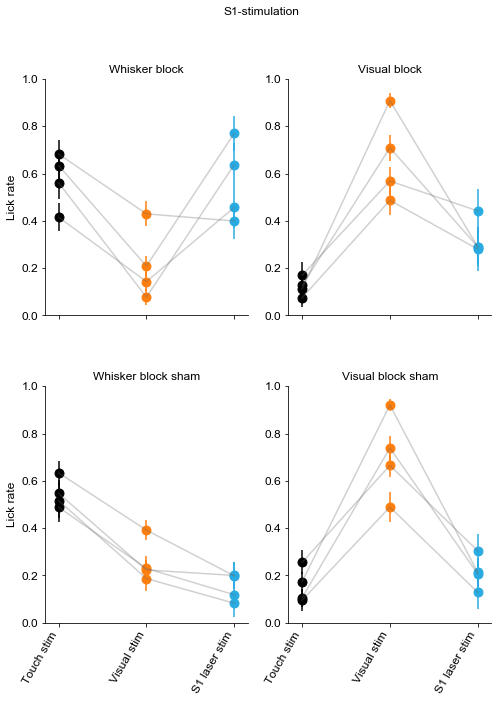

In [19]:
fig, axes = mpl.subplots(2,2, figsize = (8,10), sharex = True)
axes = axes.ravel()
mice = np.unique(np.array([mouse[0] for mouse in beh_performance.keys()]))
for mouse in mice:
    plot_perf(beh_performance[(mouse, 'stim')][0],beh_performance[(mouse, 'stim')][1], axes[0],axes[1], subp_title = ['Whisker block', 'Visual block'])
    plot_perf(beh_performance[(mouse, 'sham')][0],beh_performance[(mouse, 'sham')][1], axes[2],axes[3], subp_title = ['Whisker block sham', 'Visual block sham'])



# plot_perf(beh_performance[('YT045', 'long')][0],beh_performance[('YT045', 'long')][1], ax1,ax2)
fig.suptitle('S1-stimulation')

In [20]:
stim_session_outcomes = beh_log_test.loc[beh_log_test['session_type'] == 'stim',['mouse_name', 'block_type','stim_type','resp', 'correct']]
stim_session_outcomes['lick'] = (stim_session_outcomes['resp'] != 0)*1
grouped_correct_licks = stim_session_outcomes[['mouse_name', 
                                              'block_type', 
                                              'lick',
                                              'stim_type',]].groupby(['mouse_name', 'block_type','stim_type'])

sham_session_outcomes = beh_log_test.loc[beh_log_test['session_type'] == 'sham',['mouse_name', 'block_type','stim_type','resp', 'correct']]
sham_session_outcomes['lick'] = (sham_session_outcomes['resp'] != 0)*1
sham_grouped_correct_licks = sham_session_outcomes[['mouse_name', 
                                              'block_type', 
                                              'lick',
                                              'stim_type',]].groupby(['mouse_name', 'block_type','stim_type'])


def multilevel_bootstrap(gr_df, gr1, gr2, num_iter):
    
    all_resampled_stats = []
    for i in tnrange(num_iter):

        across_mice_resample = []

        ##### resample mice with replacement ###############
        mice = ['EF0147', 'EF0148', 'EF0149', 'EF0150']
        resamp_mice = np.random.choice(mice, size = len(mice), replace = True)

        for mouse in resamp_mice:
            ############# stratefied resampling of trials within mouse with replacement ###########
            gr_2 = tuple([mouse]  + gr2)
            gr_1 = tuple([mouse]  + gr1)
            #queries gr_df for groups we want to compare
            cond1 = gr_df.get_group(gr_1) 
            cond2 = gr_df.get_group(gr_2)

            cond1_resample = cond1.sample(frac = 1, replace = True)
            cond2_resample = cond2.sample(frac = 1, replace = True)

            mouse_lick_prob_diff = cond1_resample['lick'].mean() - cond2_resample['lick'].mean()
            across_mice_resample.append(mouse_lick_prob_diff)

        all_resampled_stats.append(np.mean(across_mice_resample))
        
    sorted_stats = np.sort(all_resampled_stats)
    return sorted_stats

In [21]:
beh_log_test.loc[beh_log_test['session_type'] == 'sham', ['mouse_name', 'date']].drop_duplicates()

,mouse_name,date
578,EF0147,12-14-18
884,EF0147,12-15-18
1556,EF0147,12-17-18
1881,EF0148,12-10-18
2982,EF0148,12-17-18
3288,EF0149,12-11-18
3837,EF0149,12-14-18
4516,EF0149,12-16-18
5525,EF0150,12-17-18
6186,EF0150,12-19-18


In [22]:
num_iter = 10000
stim_stats = {
    'tac_nolaser':multilevel_bootstrap(grouped_correct_licks, ['Whisker', 'catch'], ['Whisker', 'Stim_Som_NoCue'], num_iter = num_iter),
    'vis_nolaser':multilevel_bootstrap(grouped_correct_licks, ['Visual', 'catch'], ['Visual', 'Stim_Vis_NoCue'], num_iter = num_iter),
}

sham_stats = {
    'tac_nolaser':multilevel_bootstrap(sham_grouped_correct_licks, ['Whisker', 'catch'], ['Whisker', 'Stim_Som_NoCue'], num_iter = num_iter),
    'vis_nolaser':multilevel_bootstrap(sham_grouped_correct_licks, ['Visual', 'catch'], ['Visual', 'Stim_Vis_NoCue'], num_iter = num_iter),
}

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [23]:
def calc_mean_diff(label,mouse_session):
    diff_stats = {
        'mouse':[label[0]],
        'session':[label[1]],
        'tac_nolaser': mouse_session[0][('Whisker', 'catch')]-mouse_session[0][('Whisker', 'Stim_Som_NoCue')],
        'vis_nolaser':mouse_session[0][('Visual', 'catch')]-mouse_session[0][('Visual', 'Stim_Vis_NoCue')],
    }
    return pd.DataFrame.from_dict(diff_stats)
    
mean_diffs = pd.concat([calc_mean_diff(label, mouse_session) for label, mouse_session in beh_performance.items()]).reset_index(drop = True)

In [24]:
import matplotlib.patches as patches
from utils import utils


In [25]:
mean_diffs

,mouse,session,tac_nolaser,vis_nolaser
0,EF0147,sham,-0.370204,-0.361246
1,EF0147,stim,0.136264,-0.126661
2,EF0148,sham,-0.433860,-0.360722
3,EF0148,stim,0.076555,-0.206662
4,EF0149,sham,-0.347079,-0.532235
5,EF0149,stim,0.041315,-0.418477
6,EF0150,sham,-0.435344,-0.707763
7,EF0150,stim,-0.282972,-0.617861


In [26]:
def prettify_ax(ax, x_label, y_label, y_lim = None, x_lim = None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if y_lim:
        ax.set_ylim(y_lim)
        
    if x_lim:
        ax.set_xlim(x_lim)
        
    return ax

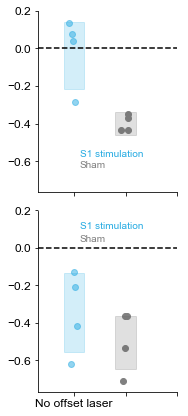

In [27]:
fig, (ax,ax1) = mpl.subplots(2,1, figsize = (2.5,7), sharey = True)

for a, mod, color in zip([ax,ax1], ['tac', 'vis'], ['#26ABE2', '#26ABE2']):
    for i, group in enumerate([mod+'_nolaser']):
        conf = [int(num_iter*0.025), int(num_iter*0.975)]
        a.scatter(np.random.randn(4)*0.025+i, mean_diffs.loc[mean_diffs['session'] == 'stim', group], color = color, alpha = 0.5)
        a.add_patch(patches.Rectangle((-0.1+i, stim_stats[group][conf[0]]), 0.2, stim_stats[group][conf[1]] - stim_stats[group][conf[0]], color = color, alpha = 0.2))

        a.scatter(np.random.randn(4)*0.025+i+0.5, mean_diffs.loc[mean_diffs['session'] == 'sham', group], color = [0.5,0.5,0.5])
        a.add_patch(patches.Rectangle((0.4+i, sham_stats[group][conf[0]]), 0.2, sham_stats[group][conf[1]] - sham_stats[group][conf[0]], color = [0.4,0.4,0.4], alpha = 0.2))

ax.text(0.3, 0.14, 'Sham', transform = ax.transAxes, color = [0.5,0.5,0.5])
ax1.text(0.3, 0.83, 'Sham', transform = ax1.transAxes, color = [0.5,0.5,0.5])

ax.text(0.3, 0.2, 'S1 stimulation', transform = ax.transAxes, color = '#26ABE2')
ax1.text(0.3, 0.9, 'S1 stimulation', transform = ax1.transAxes, color = '#26ABE2')
ax.set_xticks([0,0.5,1,1.5])
ax.set_xticklabels([])
ax1.set_xticks([0,0.5,1,1.5])

ax1.set_xticklabels(['No offset laser', '', '', '50ms offset laser'])

for a in (ax, ax1):
    prettify_ax(a, x_label = '', y_label = '')
    a.axhline(0, linestyle = '--', color = 'k')
    a.set_xlim(-0.35,1)
#     a.set_ylim(-0.7,0.2)
mpl.subplots_adjust(hspace = 0.1)
fig.savefig('Fig7_stim_diff.pdf',format='pdf', dpi=900, transparent = True)

In [28]:
gr2 = ['Whisker', 'Stim_Som_NoCue']
gr1 = ['Whisker', 'catch']
num_iter = 10000
sorted_stats = multilevel_bootstrap(grouped_correct_licks, gr1, gr2, num_iter = num_iter)
print(f"95% CI: {sorted_stats[int(0.025*num_iter)], sorted_stats[int(0.975*num_iter)]}")
print(f"99% CI: {sorted_stats[int(0.005*num_iter)], sorted_stats[int(0.995*num_iter)]}")

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


95% CI: (-0.21653609019814174, 0.13903136600045335)
99% CI: (-0.2623761256491071, 0.1627383726407463)


In [29]:
gr2 = ['Visual', 'Stim_Vis_NoCue']
gr1 = ['Visual', 'catch']
num_iter = 10000
sorted_stats1 = multilevel_bootstrap(grouped_correct_licks, gr1, gr2, num_iter = num_iter)
print(f"95% CI: {sorted_stats1[int(0.025*num_iter)], sorted_stats1[int(0.975*num_iter)]}")
print(f"99% CI: {sorted_stats1[int(0.005*num_iter)], sorted_stats1[int(0.995*num_iter)]}")

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


95% CI: (-0.5536925936393104, -0.14305258074188537)
99% CI: (-0.5988538979214193, -0.09582771240192701)


In [30]:
print('---------------Touch block, Touch stim/Laser stim---------------')
print(f"\n95% CI: {sorted_stats[int(0.025*num_iter)], sorted_stats[int(0.975*num_iter)]}")
print(f"99% CI: {sorted_stats[int(0.005*num_iter)], sorted_stats[int(0.995*num_iter)]}\n\n")

print('---------------Visual block, Visual stim/Laser stim---------------')
print(f"\n95% CI: {sorted_stats1[int(0.025*num_iter)], sorted_stats1[int(0.975*num_iter)]}")
print(f"99% CI: {sorted_stats1[int(0.005*num_iter)], sorted_stats1[int(0.995*num_iter)]}\n\n")


---------------Touch block, Touch stim/Laser stim---------------

95% CI: (-0.21653609019814174, 0.13903136600045335)
99% CI: (-0.2623761256491071, 0.1627383726407463)


---------------Visual block, Visual stim/Laser stim---------------

95% CI: (-0.5536925936393104, -0.14305258074188537)
99% CI: (-0.5988538979214193, -0.09582771240192701)




In [31]:
def select_treatment_group(data, treatment, group):
    inh_groups = {key[0]:data[key][0] for key in data.keys() if key[1] == treatment}
    mouse_means = [inh_groups[mouse][group] for mouse in inh_groups.keys()]
    return mouse_means

In [32]:
cond1 = select_treatment_group(beh_performance, 'stim', ('Whisker', 'Stim_Som_NoCue'))
cond2 = select_treatment_group(beh_performance, 'stim', ('Whisker', 'catch'))
cond3 = select_treatment_group(beh_performance, 'stim', ('Visual', 'Stim_Vis_NoCue'))
cond4 = select_treatment_group(beh_performance, 'stim', ('Visual', 'catch'))
S1_opto_vs_touch = stats.ttest_rel(cond1, cond2)
S1_opto_vs_vis = stats.ttest_rel(cond3, cond4)
# no_laser_vs_full = stats.ttest_rel(cond1, cond3)

In [33]:
print(f"S1 stim vs touch stim (touch block):{S1_opto_vs_touch.pvalue/2} \nS1 stim vs visual stim (visual block): {S1_opto_vs_vis.pvalue/2}")

S1 stim vs touch stim (touch block):0.4718431543222022 
S1 stim vs visual stim (visual block): 0.026697768219805483


In [34]:
fig.savefig('S1_stim_behvior.pdf', format = 'pdf', dpi = 900)

In [35]:
os.getcwd()

'C:\\Users\\efink\\Documents\\Data\\crossmodal_only'

In [37]:
beh_log_test['trial_num_group'] = beh_log_test['trial_num'].apply(lambda x: np.int(np.floor(x/4)))

In [38]:
3.451*.75

2.58825

In [39]:
catch_alone =  beh_log_test[beh_log_test['stim_type'] == 'catch']
catch_grouped = catch_alone.groupby(['mouse_name', 'session_type', 'date', 'block_type', 'stim_type'])
catch_alone = catch_grouped.apply(lambda x: x.reset_index(drop=True).reset_index()[['trial_num','correct', 'resp','index']]).reset_index()
catch_alone = catch_alone.rename(columns = {'index':'trial_num_group'})
catch_alone['trial_num_group'] = np.floor(catch_alone['trial_num_group']/3)
catch_alone['trial_num_group'] = catch_alone['trial_num_group'].apply(np.int)

In [40]:
catch_grouped = catch_alone.groupby(['mouse_name', 'session_type', 'date', 'block_type', 'stim_type', 'trial_num_group'])

In [41]:
idx = pd.IndexSlice
catch_grouped['correct'].apply(np.mean).loc[idx[:, 'stim', :, 'Whisker', 'catch']]

mouse_name  date      trial_num_group
EF0147      12-11-18  0                  1.000000
                      1                  0.333333
                      2                  1.000000
                      3                  0.666667
                      4                  0.666667
                      5                  1.000000
                      6                  1.000000
                      7                  1.000000
                      8                  1.000000
            12-13-18  0                  1.000000
                      1                  0.666667
                      2                  1.000000
                      3                  1.000000
                      4                  0.000000
                      5                  0.666667
                      6                  0.333333
                      7                  0.000000
                      8                  0.000000
                      9                  1.000000
            